<a href="https://colab.research.google.com/github/LouisGraf/ADS2019/blob/master/First_Group_Bonus_06_LG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class='bar_title'></div>

*Decision Support Systems*

# Bonus 06

Louis Graf, Kevin Kronenwetter, Jonas Wolf, Timo Schmidt <br>

Winter Semester 19/20

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Standard-LP" data-toc-modified-id="Standard-LP-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Standard LP</a></span></li><li><span><a href="#Robust-Optimization" data-toc-modified-id="Robust-Optimization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Robust Optimization</a></span></li><li><span><a href="#Chance-Constraints" data-toc-modified-id="Chance-Constraints-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Chance Constraints</a></span></li><li><span><a href="#Stochastic-Programming-1" data-toc-modified-id="Stochastic-Programming-1-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Stochastic Programming 1</a></span></li><li><span><a href="#Stochastic-Programming-2" data-toc-modified-id="Stochastic-Programming-2-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Stochastic Programming 2</a></span></li></ul></div>

In [2]:
!pip install pulp
from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

     |████████████████████████████████| 39.2MB 59kB/s 


## Solar Home
![alt text](https://i.imgur.com/8wlzgr3.png)


*   Extending the system from group 3 
 * The first model assumes the daily mean value for the
available solar energy and the consumption
 * This case introduces volatile prices
*   Implementing different approaches
 * Robust Optimization
 * Chance Constraints
 * Stochastic Programming 1
 * Stochastic Programming 2









#Data Preparation

In [0]:
df_solar = pd.read_csv('https://github.com/wi3jmu/DSS1920/raw/master/Data/Solar_Data.csv', index_col=0)
df_consum = pd.read_csv('https://github.com/wi3jmu/DSS1920/raw/master/Data/Consum_Data.csv', index_col=0)

In [0]:
# we want to have day 0-365 instead of dates
days = df_consum.reset_index().index.tolist()

df_consum=df_consum.reset_index(drop=True)
df_solar=df_solar.reset_index(drop=True)



In [5]:
df_consum.head()

,consum_0,consum_1,consum_2,consum_3,consum_4,consum_5,consum_6,consum_7,consum_8,consum_9,consum_10,consum_11,consum_12,consum_13,consum_14,consum_15,consum_16,consum_17,consum_18,consum_19,consum_20,consum_21,consum_22,consum_23,consum_24,consum_25,consum_26,consum_27,consum_28,consum_29,consum_30,consum_31,consum_32,consum_33,consum_34,consum_35,consum_36,consum_37,consum_38,consum_39,...,consum_460,consum_461,consum_462,consum_463,consum_464,consum_465,consum_466,consum_467,consum_468,consum_469,consum_470,consum_471,consum_472,consum_473,consum_474,consum_475,consum_476,consum_477,consum_478,consum_479,consum_480,consum_481,consum_482,consum_483,consum_484,consum_485,consum_486,consum_487,consum_488,consum_489,consum_490,consum_491,consum_492,consum_493,consum_494,consum_495,consum_496,consum_497,consum_498,consum_499
0,79.026813,79.166693,79.603195,79.321704,78.426286,79.815542,78.060443,77.979138,79.978409,80.389137,79.983628,77.718385,78.826753,78.213426,81.529607,79.622439,79.088847,79.705980,78.777296,79.017739,79.132732,80.658701,79.690784,78.419326,79.713849,77.920537,78.286659,80.710708,80.288078,77.841154,80.332843,80.154104,79.096525,78.701293,79.006752,79.378216,78.287544,79.589120,78.900729,80.008631,...,79.479003,78.731002,77.116759,78.613561,79.264048,78.451245,77.811407,78.189922,77.646655,79.455129,80.323140,77.529353,78.735658,79.691361,81.163756,79.022683,78.537681,78.100602,79.567548,78.965276,78.672173,79.089917,76.990528,79.654411,79.446498,78.427800,78.382720,80.297832,77.312368,78.532333,76.788895,80.680322,78.984695,80.012801,79.185524,79.695756,78.573123,79.163573,78.000456,80.359045
1,78.145723,77.121751,77.307550,76.807391,79.711418,76.460352,75.988529,77.208810,78.901799,78.137209,78.327131,76.800837,77.592148,77.204121,77.220567,78.758530,78.283049,78.524081,78.764356,80.078982,78.255205,77.200663,75.603765,78.565217,78.149006,77.781233,78.503338,79.409621,77.624529,78.351365,78.757912,77.706867,76.894821,79.461543,79.016336,77.081311,78.382219,79.552381,77.981180,79.015688,...,77.805577,77.756585,77.133505,76.994955,76.999331,79.506828,78.002837,76.536134,78.690394,77.927025,78.214346,79.786492,79.150910,76.329103,76.623669,77.378768,78.046719,78.971564,78.388386,77.832902,76.692438,78.432444,77.867719,78.358724,80.210820,77.394123,79.063187,78.127170,77.647397,78.900818,80.060448,77.694551,76.057983,79.814416,79.439387,77.981815,78.109007,78.377900,78.283468,78.697465
2,67.557088,67.551236,66.104895,67.823331,67.983887,67.317197,68.318782,68.897925,68.324301,68.578712,67.489072,66.604344,67.518564,68.333429,67.749236,67.149078,67.908577,69.690595,67.425544,69.411555,66.686621,67.893034,67.481544,66.838989,68.762698,65.887169,68.605465,67.485527,68.239227,68.880257,67.662732,67.405812,67.806979,67.876469,67.807197,69.501742,68.074115,67.108040,67.865921,68.444906,...,68.083950,68.242012,67.394855,67.401678,67.464564,65.512036,68.261130,69.431548,69.403131,66.799248,68.902274,67.356914,67.981547,68.037285,68.209216,65.927135,67.125056,67.253395,68.954528,66.219790,67.011710,67.551036,69.098068,67.514062,67.094866,67.712130,68.558418,67.960915,67.055933,68.469175,66.727674,67.646057,68.218354,66.893765,67.366920,66.888175,66.818032,66.626834,68.943628,66.809443
3,48.924967,51.043785,50.011764,48.057107,48.912827,49.631908,49.234540,50.298924,49.099525,49.465574,49.501716,49.451673,50.061658,48.710608,49.050781,50.551722,47.881502,50.619277,49.905522,48.060175,49.538275,49.713193,48.177358,48.294964,48.442208,47.222726,48.684630,49.776176,49.475300,48.579748,49.811255,48.484334,50.559079,51.542947,48.622168,47.878957,49.641950,49.681159,49.703603,48.197222,...,49.566356,50.666148,48.589115,48.567081,49.221585,49.936864,50.813604,49.457281,49.523102,49.384034,50.217889,48.937132,49.179944,48.555640,49.391764,50.500473,47.206814,49.433313,50.543305,48.876097,49.834933,48.073718,50.603781,49.696105,49.536930,48.314175,48.621327,48.780312,50.246818,49.517935,47.933095,49.864442,50.377888,48.651444,5

In [6]:
df_solar.head()

,solar_0,solar_1,solar_2,solar_3,solar_4,solar_5,solar_6,solar_7,solar_8,solar_9
0,32.882083,33.528512,33.277529,33.873368,32.593289,33.582332,34.723709,33.890378,33.931324,34.700612
1,12.709871,12.278981,11.906540,13.306186,11.247804,11.964842,13.746997,13.189224,14.020067,12.965316
2,73.700604,73.458066,73.794748,73.397938,73.936536,75.131642,71.898934,74.021681,74.778660,74.111016
3,65.019633,62.821818,63.353230,63.795378,64.872601,63.624012,62.227826,64.055256,63.332238,63.844992
4,68.856726,67.962777,66.685048,68.398001,67.465437,69.204134,67.827804,68.758371,68.372007,67.796201


In [0]:
# Dictionaries for available solar energy and consumption
solar = df_solar.transpose().to_dict() 
consum = df_consum.transpose().to_dict() 

# Mean (and standard deviation) for available solar energy and consumption
solar_mean = df_solar.transpose().mean() 

consum_std = df_consum.transpose().std() 
consum_mean = df_consum.transpose().mean()

## Standard LP

In [0]:
# Parameters
batterie_cost = 84/15 #cost per kilowatt-hour per year
recycling_cost = 150 #after end of life regardless capacity
buying_price = 0.3 #per kilowatt-hour on the market

In [0]:
# Variables
solar_elec = LpVariable.dicts("solar_elec", days, lowBound=0, cat='Continuous') #solar-electricity (direct use)
buying_elec = LpVariable.dicts("buying_elec", days, lowBound=0, cat='Continuous') #buying electricity
battery_elec = LpVariable.dicts("battery_elec", days, lowBound=0, cat='Continuous') #stored electricity in battery

battery_status = LpVariable.dicts("battery_status", days, lowBound=0, cat='Continuous') #status battery
battery_charge = LpVariable.dicts("battery_charge", days, lowBound=0, cat='Continuous') #charge

batterie_kap = LpVariable("batterie_kap", lowBound=0, cat='Continuous') #Capacity

Status: Optimal
Ergebnis Systemkosten: 4573.776773859999
Kapazität Batterie: 27.080882


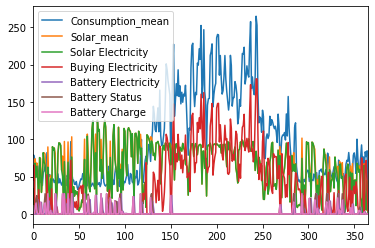

,Consumption_mean,Solar_mean,Solar Electricity,Buying Electricity,Battery Electricity,Battery Status,Battery Charge
0,79.043769,33.698314,33.698314,45.345455,0.0,0.000000,0.000000
1,78.107283,12.733583,12.733583,65.373700,0.0,0.000000,0.000000
2,67.877886,73.822982,67.877886,0.000000,0.0,5.945096,5.945096
3,49.243723,63.694698,49.243723,0.000000,0.0,20.396072,14.450976
4,63.972130,68.132651,63.972130,0.000000,0.0,24.556593,4.160521


In [10]:
# Create model
m = LpProblem("Solar_System", sense=pulp.LpMinimize) #minimize costs for buying electricity

# Objective
m += lpSum([150 + batterie_cost * batterie_kap] + [buying_price * buying_elec[t] for t in days]) #minimize costs for buying electricity

# Constraints
for t in days:
    m += solar_elec[t] + buying_elec[t] + battery_elec[t] >= consum_mean[t]
    m += solar_elec[t] + battery_charge[t] <= solar_mean[t]
    if (t==0):   
        m += 0 - battery_elec[t] + battery_charge[t] == battery_status[t]
    else:
        m += battery_status[t-1] - battery_elec[t] + battery_charge[t] == battery_status[t] 
    m += battery_status[t] <= batterie_kap 
    
# Solve problem
m.solve()

#Ergebnisse anzeigen:
print ('Status: ' + LpStatus[m.status])
print ('Ergebnis Systemkosten: ' + str(value(m.objective)))
print('Kapazität Batterie: ' + str(batterie_kap.varValue))

#Ergebnisse an Variablen übergeben:
kap = batterie_kap.varValue
value_standard = value(m.objective)
for t in days:
  buying_standard = buying_elec[t].varValue
  
#Ergebnisse in Diagramm darstellen:
out = pd.DataFrame([[consum_mean[t], solar_mean[t],  solar_elec[t].varValue, buying_elec[t].varValue, battery_elec[t].varValue, battery_status[t].varValue, battery_charge[t].varValue] for t in days],
                   columns = ['Consumption_mean', 'Solar_mean', 'Solar Electricity', 'Buying Electricity', 'Battery Electricity', 'Battery Status', 'Battery Charge'])
out.plot()
plt.show()
out.head()

## Robust Optimization - Louis

*Task:* 
* Use the dictionaries with the 500 series of daily consumption and 10 series of daily available solar energy to determine the ranges of uncertainty

*Why do we need Robust Optimization?*
* Find solution that is always feasible and near optimal in all situations


Lecture Slide:

* For each functional constraint in **≤** form, we use the **maximum** value of each **$a_{ij}$** and the **minimum** value of **$b_{i}$**
* For each functional constraint in **≥** form, we use the **minimum** value of each $𝑎_{ij}$ and the **maximum** value of $b_i$
* For an objective function in **maximization** form, use the **minimum** value of each $c_j$
* For an objective function in **minimization** form, use the **maximum** value of each $c_j$

$i = t$ index i represents days t

$a_{t}$ = Consumption per day

$b_t$ = Production per day

$c_t$ = Cost per day


In [0]:
#min/max-Values of the timeseries
solar_min = df_solar.transpose().min() #Min Value of Solar per day
solar_max = df_solar.transpose().max() #Max Value 

consum_min = df_consum.transpose().min() #Min Value of consumption per day
consum_max = df_consum.transpose().max() #Max Value

Status: Optimal
Total Cost: 4931.157830228003
Battery Capacity: 30.079138


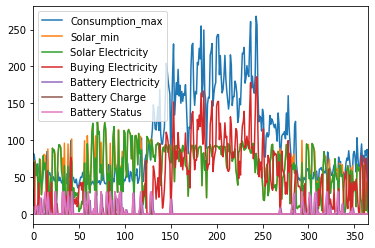

,Consumption_max,Solar_min,Solar Electricity,Buying Electricity,Battery Electricity,Battery Charge,Battery Status
0,81.529607,32.593289,32.593289,48.936318,0.000000,0.000000,0.000000
1,80.987056,11.247804,11.247804,69.739252,0.000000,0.000000,0.000000
2,70.784051,71.898934,70.784051,0.000000,0.000000,1.114882,1.114882
3,52.065457,62.227826,52.065457,0.000000,0.000000,10.162369,11.277251
4,67.389934,66.685048,66.685048,0.000000,0.704886,0.000000,10.572365


In [12]:
# Worst Case Robust Model
mrw = LpProblem("Solar_System_Robust_Worst", sense=pulp.LpMinimize) #minimize costs for buying electricity

# Objective
mrw += lpSum([150 + batterie_cost * batterie_kap] + [buying_price * buying_elec[t] for t in days]) #minimize costs for buying electricity
#Sum(recycling-costs + battery-costs(yearly) * Battery_capacity + price-electricity * amount-electricity_bought) in 365 days

# Constraints
for t in days:
    mrw += solar_elec[t] + buying_elec[t] + battery_elec[t] >= consum_max[t] #There needs to be enough energy to supply the max_consumption
    # aij >= max bi
    mrw += solar_elec[t] + battery_charge[t] <= solar_min[t] #Direct consumption and storage per day cannot be greater than daily solar_min
    # aij <= min bi

    if (t==0):   
        mrw += 0 - battery_elec[t] + battery_charge[t] == battery_status[t]
    else:
        mrw += battery_status[t-1] - battery_elec[t] + battery_charge[t] == battery_status[t]
        
    mrw += battery_status[t] <= batterie_kap
    

# Solve problem
mrw.solve()

#Print Solution:
print ('Status: ' + LpStatus[m.status])
print ('Total Cost: ' + str(value(mrw.objective)))
print('Battery Capacity: ' + str(batterie_kap.varValue))

#Save solution:
kap = batterie_kap.varValue
value_worstcase = value(mrw.objective)

#Plot Solution:
out = pd.DataFrame([[consum_max[t], solar_min[t],  solar_elec[t].varValue, buying_elec[t].varValue, battery_elec[t].varValue, battery_charge[t].varValue, battery_status[t].varValue] for t in days],
                   columns = ['Consumption_max', 'Solar_min', 'Solar Electricity', 'Buying Electricity', 'Battery Electricity', 'Battery Charge', 'Battery Status'])
out.plot()
plt.show()
out.head()

Status: Optimal
Ergebnis Systemkosten: 4235.070887244
Kapazität Batterie: 27.145122


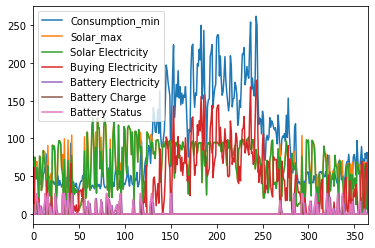

,Consumption_min,Solar_max,Solar Electricity,Buying Electricity,Battery Electricity,Battery Charge,Battery Status
0,75.878005,34.723709,34.723709,41.154296,0.0,0.000000,0.000000
1,75.221628,14.020067,14.020067,61.201560,0.0,0.000000,0.000000
2,65.036758,75.131642,74.618311,0.000000,0.0,0.513331,0.513331
3,46.351681,65.019633,46.351681,0.000000,0.0,18.667952,19.181283
4,61.240295,69.204134,61.240295,0.000000,0.0,7.963839,27.145122


In [13]:
# Best Case Robust Model
mrb = LpProblem("Solar_System_Robust_Best", sense=pulp.LpMinimize) #minimize costs for buying electricity

# Objective
mrb += lpSum([150 + batterie_cost * batterie_kap] + [buying_price * buying_elec[t] for t in days])

# Constraints
for t in days:
    mrb += solar_elec[t] + buying_elec[t] + battery_elec[t] >= consum_min[t] #Min Consumption
    # aij >= min bi
    mrb += solar_elec[t] + battery_charge[t] <= solar_max[t] #Max Production
    # aij <= max bi

    if (t==0):   
        mrb += 0 - battery_elec[t] + battery_charge[t] == battery_status[t]
    else:
        mrb += battery_status[t-1] - battery_elec[t] + battery_charge[t] == battery_status[t] 
    mrb += battery_status[t] <= batterie_kap 
    
# Solve problem
mrb.solve()

#Print Solution:
print ('Status: ' + LpStatus[m.status])

print ('Ergebnis Systemkosten: ' + str(value(mrb.objective)))

print('Kapazität Batterie: ' + str(batterie_kap.varValue))

#Save solution:
kap = batterie_kap.varValue

value_bestcase = value(mrb.objective)

#Plot solution:
out = pd.DataFrame([[consum_min[t], solar_max[t],  solar_elec[t].varValue, buying_elec[t].varValue, battery_elec[t].varValue, battery_charge[t].varValue, battery_status[t].varValue] for t in days],
                   columns = ['Consumption_min', 'Solar_max', 'Solar Electricity', 'Buying Electricity', 'Battery Electricity', 'Battery Charge', 'Battery Status'])
out.plot()
plt.show()
out.head()

In [14]:
#ranges of uncertainty:
rng_uncertainty = value_bestcase - value_worstcase

print('Solution standard LP                                     ' + str(value_standard))
print('Solution robust optimization   -> worst case:            ' + str(value_worstcase))
print('Solution robust optimization   -> best case:             ' + str(value_bestcase))
print('Solution robust optimization   -> range of uncertainty:  ' + str(rng_uncertainty))


Solution standard LP                                     4573.776773859999
Solution robust optimization   -> worst case:            4931.157830228003
Solution robust optimization   -> best case:             4235.070887244
Solution robust optimization   -> range of uncertainty:  -696.0869429840031


## Chance Constraints - Jonas
Task:
* Consumption now is an uncertain parameter (random variable) in the model. Use the mean and the standard deviation of the normally distributed consumption data. Let 0.9 be the minimum acceptable probability that the original constraint will hold.
* Continue to use the robust optimization approach for
the available solar energy

###from lecture
  **original constraint:**

  solar_elec + buying_elec + battery_elec >= consum

  **chance constraint:**

  solar_elec + buying_elec + battery_elec >= consum_mean + $Q_a$ * consum_std

  $Q_a$ = +1.282 for $>=$

  $Q_a$ = -1.282 for $<=$

Status: Optimal
Ergebnis Systemkosten: 4792.291993814999
Kapazität Batterie: 31.117698


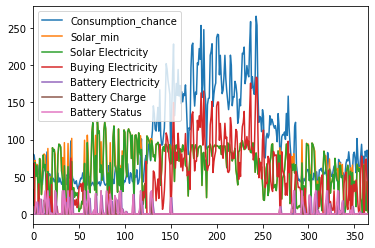

,Consumption_chance,Solar_min,Solar Electricity,Buying Electricity,Battery Electricity,Battery Charge,Battery Status
0,80.303175,32.593289,32.593289,47.709445,0.0,0.000000,0.000000
1,79.346883,11.247804,11.247804,68.098645,0.0,0.000000,0.000000
2,69.121861,71.898934,69.121426,0.000000,0.0,2.777508,2.777508
3,50.530994,62.227826,50.530544,0.000000,0.0,11.697282,14.474789
4,65.179877,66.685048,65.179455,0.000000,0.0,1.505593,15.980383


In [15]:
#additional variables
q = norm.ppf(0.9) #1.282 from standard normal table

# Create chance constraints model
mc = LpProblem("Solar_System_Chance", sense=pulp.LpMinimize) #minimize costs for buying electricity

# Objective
mc += lpSum([150 + batterie_cost * batterie_kap] + [buying_price * buying_elec[t] for t in days]) 

# Constraints
for t in days:
    mc += solar_elec[t] + buying_elec[t] + battery_elec[t] >= consum_mean[t] + (consum_std[t] *  q)
    # Modified Constraints -> chance constraint
    mc += solar_elec[t] + battery_charge[t] <= solar_min[t]
    # max aij <= min bi (robust optimization for solar)

    if (t==0):   
        mc += 0 - battery_elec[t] + battery_charge[t] == battery_status[t]
    else:
        mc += battery_status[t-1] - battery_elec[t] + battery_charge[t] == battery_status[t]
        
    mc += battery_status[t] <= batterie_kap
    
# Solve problem
mc.solve()

#Print Solution:
print ('Status: ' + LpStatus[m.status])
print ('Ergebnis Systemkosten: ' + str(value(mc.objective)))
print('Kapazität Batterie: ' + str(batterie_kap.varValue))

#Save Solution:
kap = batterie_kap.varValue
value_chance = value(mc.objective)

#Plot Solution:
out = pd.DataFrame([[(consum_mean[t] + (consum_std[t] *  1.282)), solar_min[t],  solar_elec[t].varValue, buying_elec[t].varValue, battery_elec[t].varValue, battery_charge[t].varValue, battery_status[t].varValue] for t in days],
                   columns = ['Consumption_chance', 'Solar_min', 'Solar Electricity', 'Buying Electricity', 'Battery Electricity', 'Battery Charge', 'Battery Status'])
out.plot()
plt.show()
out.head()

In [16]:
#Compare Results (Robust):
print('Ergebnis standard LP                                             ' + str(value_standard))
print('Ergebnis robust optimization   -> worst case:                    ' + str(value_worstcase))
print('Ergebnis robust optimization   -> best case:                     ' + str(value_bestcase))
print('Ergebnis robust optimization   -> range of uncertainty robust:   ' + str(rng_uncertainty))


print('')
#Compare Results (Chance):
rng2_uncertainty = value_standard - value_chance
print('Ergebnis standard LP                                             ' + str(value_standard))
print('Ergebnis chance constraints                                      ' + str(value_chance))
print('Ergebnis chance constraints    -> range of uncertainty chance:   ' + str(rng2_uncertainty))

Ergebnis standard LP                                             4573.776773859999
Ergebnis robust optimization   -> worst case:                    4931.157830228003
Ergebnis robust optimization   -> best case:                     4235.070887244
Ergebnis robust optimization   -> range of uncertainty robust:   -696.0869429840031

Ergebnis standard LP                                             4573.776773859999
Ergebnis chance constraints                                      4792.291993814999
Ergebnis chance constraints    -> range of uncertainty chance:   -218.51521995500025


## Stochastic Programming 1 - Timo / Kevin

Task: 
* The specified price for each kilowatt-hour of
electricity is only an estimate. Several economists
estimate the future price of electricity differently.
Each of these analyses has the same probability of
occurrence.
* However, the battery capacity still needs to be
decided before the system is set up.

**non-recourse-variable:** batterie-kap

**recourse-variable:** buying_elec


In [0]:
# different scenarios for the buying price
buying_price = [0.28, 0.3, 0.32, 0.35, 0.4, 0.5] #mean: 0,358333333
scenarios = range(len(buying_price))
days_scenarios = [(t,s) for s in scenarios for t in days]

Status: Optimal
Ergebnis Systemkosten: 5402.729966809166
Kapazität Batterie: 32.107291


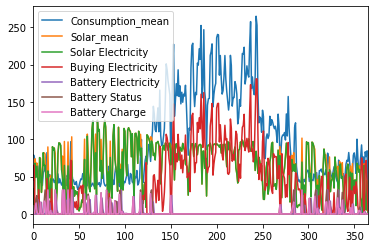

,Consumption_mean,Solar_mean,Solar Electricity,Buying Electricity,Battery Electricity,Battery Status,Battery Charge
0,79.043769,33.698314,33.698314,45.345455,0.0,0.000000,0.000000
1,78.107283,12.733583,12.733583,65.373700,0.0,0.000000,0.000000
2,67.877886,73.822982,67.877886,0.000000,0.0,5.945096,5.945096
3,49.243723,63.694698,49.243723,0.000000,0.0,20.396072,14.450976
4,63.972130,68.132651,63.972130,0.000000,0.0,24.556593,4.160521


In [18]:
# Create model
ms = LpProblem("Solar_System_Stochastic1", sense=pulp.LpMinimize) #minimize costs for buying electricity

# Objective
ms += [150 + batterie_cost * batterie_kap] + lpSum(1/len(buying_price) * buying_price[s] * buying_elec[t] for t in days for s in scenarios)

# Constraints
for t in days:
    ms += solar_elec[t] + buying_elec[t] + battery_elec[t] >= consum_mean[t]
    
    ms += solar_elec[t] + battery_charge[t] <= solar_mean[t]

    if (t==0):   
        ms += 0 - battery_elec[t] + battery_charge[t] == battery_status[t]
    else:
        ms += battery_status[t-1] - battery_elec[t] + battery_charge[t] == battery_status[t] 
        
    ms += battery_status[t] <= batterie_kap


# Solve problem
ms.solve()

#Print Solution:
print ('Status: ' + LpStatus[ms.status])
print ('Ergebnis Systemkosten: ' + str(value(ms.objective)))
print('Kapazität Batterie: ' + str(batterie_kap.varValue))

#Save Solution:
kap = batterie_kap.varValue

value_stochastic1 = value(ms.objective)

for t in days:
  buying_stochastic1 = buying_elec[t].varValue

#Plot Solution:
out = pd.DataFrame([[consum_mean[t], solar_mean[t],  solar_elec[t].varValue, buying_elec[t].varValue, battery_elec[t].varValue, battery_status[t].varValue, battery_charge[t].varValue] for t in days],
                   columns = ['Consumption_mean', 'Solar_mean', 'Solar Electricity', 'Buying Electricity', 'Battery Electricity', 'Battery Status', 'Battery Charge'])
out.plot()
plt.show()
out.head()

## Stochastic Programming 2 - Kevin / Timo

Task:
* The energy supplier offers a special option. For a
one-time payment of 1€/kWh you get a reduced
price of 80% up to the option limit (in kWh).
However, the level of the option must be fixed at
the beginning.

**non-recourse variable:** option limit

**recourse variable:** buying_elec_discount, buying_elec


**objective function:**

min ((Recycling-Kosten Batterie + Anschaffungskosten * Kapazität) + Kosten Options-Limit) + $\sum_{t=0}^{365}$(Menge Energie reduziert * Energiepreis(s) * Rabatt(0,8)) +  $\sum_{t=0}^{365}$(Menge Energie * Energiepreis(s))

Status: Optimal
Ergebnis Systemkosten: 4520.921695115661
Kapazität Batterie: 27.080882
Option-limit: 121.30819


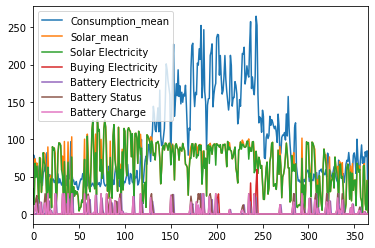

,Consumption_mean,Solar_mean,Solar Electricity,Buying Electricity,Battery Electricity,Battery Status,Battery Charge
0,79.043769,33.698314,33.698314,0.0,0.0,0.000000,0.000000
1,78.107283,12.733583,12.733583,0.0,0.0,0.000000,0.000000
2,67.877886,73.822982,67.877886,0.0,0.0,5.945096,5.945096
3,49.243723,63.694698,49.243723,0.0,0.0,20.396072,14.450976
4,63.972130,68.132651,63.972130,0.0,0.0,24.556593,4.160521


In [19]:
#additional variables:
option_limit = LpVariable("option_limit", lowBound=0, cat='Continuous')
buying_elec_discount = LpVariable.dicts("buying_elec_discount", days, lowBound=0, cat='Continuous')

# Create model
ms2 = LpProblem("Solar_System_Stochastic2", sense=pulp.LpMinimize) #minimize costs for buying electricity

# Objective
ms2 += [150 + batterie_cost * batterie_kap] + option_limit * 1 + lpSum((1/len(buying_price)) * buying_price[s] * 0.8 * buying_elec_discount[t] for t in days for s in scenarios) + lpSum((1/len(buying_price)) * buying_price[s] * buying_elec[t] for t in days for s in scenarios)

#minimize costs for buying electricity
#Adding (price-electricity * discounted_mount-electricity_bought * 0.8) + (price-electricity * amount-electricity_bought) for 365 days

# Constraints
for t in days:
    ms2 += solar_elec[t] + buying_elec_discount[t] + buying_elec[t] + battery_elec[t] >= consum_mean[t] #Buying from 4 sources now
    
    ms2 += solar_elec[t] + battery_charge[t] <= solar_mean[t] 
    
    if (t==0):   
        ms2 += 0 - battery_elec[t] + battery_charge[t] == battery_status[t]
    else:
        ms2 += battery_status[t-1] - battery_elec[t] + battery_charge[t] == battery_status[t]
        
    ms2 += battery_status[t] <= batterie_kap

    ms2 += buying_elec_discount[t] <= option_limit #Amount of discounted energy can not be greater than the option_limit


# Solve problem
ms2.solve()
print ('Status: ' + LpStatus[ms2.status])

#Show Solution:
print ('Ergebnis Systemkosten: ' + str(value(ms2.objective)))
print('Kapazität Batterie: ' + str(batterie_kap.varValue))
print('Option-limit: ' + str(option_limit.varValue))

#Save Variable.
kap = batterie_kap.varValue
value_stochastic2 = value(ms2.objective)

for t in days:
  buying_stochastic = buying_elec_discount[t].varValue

#Plot Solution
out = pd.DataFrame([[consum_mean[t], solar_mean[t],  solar_elec[t].varValue, buying_elec[t].varValue, battery_elec[t].varValue, battery_status[t].varValue, battery_charge[t].varValue] for t in days],
                   columns = ['Consumption_mean', 'Solar_mean', 'Solar Electricity', 'Buying Electricity', 'Battery Electricity', 'Battery Status', 'Battery Charge'])
out.plot()
plt.show()
out.head()

In [20]:
for t in days:
  buying_stochastic = buying_elec_discount[t].varValue
  print(buying_stochastic)

45.345455
65.3737
0.0
0.0
0.0
0.0
32.537481
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
52.393536
0.0
0.0
21.512591
0.0
33.507246
0.0
0.0
0.0
0.0
0.0
9.3535564
0.0
0.0
0.0
0.0
0.0
0.0
5.0264086
0.0
0.0
19.714061
18.054804
0.0
0.0
37.306601
71.825162
0.0
8.5089506
8.6653135
15.866911
8.360021
16.661215
5.8107402
9.323541
33.823181
35.125777
37.605265
27.450155
38.472109
4.5036826
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1612269
0.0
0.0
0.0
0.0
0.0
0.0
32.203922
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.8175269
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.2782333
27.716457
19.462763
29.259375
68.555387
0.0
0.0
0.0
0.0
0.0
0.0
0.0
55.941429
52.501925
40.326264
14.9773
31.858935
44.939086
18.237873
90.93128
65.223038
31.422834
3.5273308
11.890429
28.56173
55.870896
106.65427
102.07261
92.940203
74.311531
64.940871
0.0
52.159826
95.850789
121.30819
85.292895
59.398237
80.376716
69.866174
106.63028
85.321438
82